In [1]:
import os
import pandas as pd

# Path to the output folder containing patient subfolders
output_folder = 'output'

# List to store combined data
combined_data = []

# Iterate through each patient folder
for patient_id in os.listdir(output_folder):
    patient_folder = os.path.join(output_folder, patient_id)
    if os.path.isdir(patient_folder):
        ecg_path = os.path.join(patient_folder, 'ecg_1hour_segment.csv')
        clinical_path = os.path.join(patient_folder, 'clinical_data.csv')
        
        # Check if both files exist
        if os.path.exists(ecg_path) and os.path.exists(clinical_path):
            # Read ECG data
            ecg_df = pd.read_csv(ecg_path)
            
            # Assuming the ECG data is stored in one or multiple columns,
            # you can concatenate all columns row-wise as a string or
            # flatten the dataframe in a way you prefer.
            # Here we convert the entire ECG dataframe into a list of lists,
            # then into strings per row and join by a delimiter for each patient.
            
            # Convert each row of ECG data into a string joined by commas
            ecg_data_strings = ecg_df.astype(str).agg(','.join, axis=1).tolist()
            # Join all rows as a single string separated by semicolon (or other delimiter)
            ecg_data = ';'.join(ecg_data_strings)
            
            # Read clinical data and extract outcome label
            clinical_df = pd.read_csv(clinical_path)
            
            # Extract outcome value; assuming there is a column named 'outcome'
            # Use .str.lower() for case-insensitive matching
            outcome_value = clinical_df['Outcome'].iloc[0].strip().lower()
            
            # Convert outcome to label 1 or 0
            if outcome_value == 'good':
                label = 1
            elif outcome_value == 'poor':
                label = 0
            else:
                # If outcome value is not recognized, skip this patient or handle accordingly
                print(f"Warning: Unrecognized outcome '{outcome_value}' for patient {patient_id}. Skipping.")
                continue
            
            # Append to combined data list
            combined_data.append({
                'patient_id': patient_id,
                'data': ecg_data,
                'label': label
            })
        else:
            print(f"Warning: Missing ECG or clinical data for patient {patient_id}. Skipping.")



# Convert combined data to DataFrame
combined_df = pd.DataFrame(combined_data)

# Save combined data to CSV
combined_df.to_csv('combined_patient_ecg_outcome.csv', index=False)

In [2]:
combined_df.head()

,patient_id,data,label
0,0284,24433.0 24317.0 24354.0 24377.0 24270.0 24272....,1
1,0286,-31920.0 -31920.0 -31920.0 -31920.0 -31920.0 -...,1
2,0296,3221.0 3274.0 3380.0 3098.0 2843.0 2910.0 3274...,1
3,0299,18584.0 18488.0 18648.0 19008.0 19239.0 19347....,1
4,0303,26985.0 10038.0 -9400.0 -20411.0 -18704.0 -419...,1


In [3]:
df = combined_df

In [4]:
import pandas as pd
import numpy as np
import os
from scipy.signal import butter, filtfilt, resample_poly
import matplotlib.pyplot as plt

# --- Step 1: Load CSV file ---
df = pd.read_csv('combined_patient_ecg_outcome.csv')

# --- Step 2: Parsing function for space-separated ECG string to 1D numpy array ---

def string_to_float_array_fixed(s):
    values = []
    for val in s.strip().split():
        try:
            values.append(float(val))
        except:
            values.append(np.nan)
    return np.array(values)

df['data_array'] = df['data'].apply(string_to_float_array_fixed)

# --- Step 3: NaN interpolation helper ---

def interpolate_nan(data):
    n = len(data)
    if n == 0:
        return data

    indices = np.arange(n)
    valid = ~np.isnan(data)

    if valid.sum() == 0:
        return np.zeros_like(data)

    return np.interp(indices, indices[valid], data[valid])

# --- Step 4: Save raw numpy arrays with NaNs interpolated ---

np_folder = 'ecg_numpy_arrays'
os.makedirs(np_folder, exist_ok=True)

for _, row in df.iterrows():
    patient_id = row['patient_id']
    ecg_array = row['data_array']
    ecg_array_clean = interpolate_nan(ecg_array)
    np.save(os.path.join(np_folder, f"{patient_id}_ecg.npy"), ecg_array_clean)

print(f"Saved {len(df)} raw ECG numpy files with NaNs interpolated.")

Saved 99 raw ECG numpy files with NaNs interpolated.


In [5]:
from scipy.signal import butter, filtfilt, resample_poly, medfilt

In [6]:
# For each raw ECG file:

# Load the raw ECG array.

# Resample it to 45 Hz.

# Remove outliers by clipping extreme values.

# Apply the Butterworth low-pass filter to denoise.

# Save the cleaned, filtered ECG array to disk.

# --- Step 5: Butterworth low-pass filter ---
def butter_lowpass(cutoff, fs, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=4):
    b, a = butter_lowpass(cutoff, fs, order=order)
    data = data[:, np.newaxis] if data.ndim == 1 else data
    filtered = filtfilt(b, a, data, axis=0)
    return filtered.squeeze()

# --- Step 6: Resample function ---
def resample_ecg(data, original_fs, target_fs):
    from math import gcd
    g = gcd(int(original_fs), int(target_fs))
    up = int(target_fs // g)
    down = int(original_fs // g)
    data = data[:, np.newaxis] if data.ndim == 1 else data
    resampled = resample_poly(data, up, down, axis=0)
    return resampled.squeeze()

# --- Step 7: Median filter for spike removal --- 
# Median filter effectively removes sharp noise spikes without blurring QRS peaks.

def median_filter_denoise(signal, kernel_size=5):
    return medfilt(signal, kernel_size=kernel_size)

# --- Step 8: Full processing pipeline ---
original_fs = 310.0
target_fs = 45.0
cutoff_frequency = 20.0
filter_order = 4
median_kernel_size = 5

filtered_folder = 'ecg_resampled_filtered_arrays'
os.makedirs(filtered_folder, exist_ok=True)

for filename in os.listdir(np_folder):
    if filename.endswith('.npy'):
        file_path = os.path.join(np_folder, filename)
        ecg_data = np.load(file_path)

        # Resample
        ecg_resampled = resample_ecg(ecg_data, original_fs, target_fs)

        # Median filter for spike noise removal
        ecg_median = median_filter_denoise(ecg_resampled, kernel_size=median_kernel_size)

        # Butterworth lowpass filter for smoothing
        ecg_filtered = butter_lowpass_filter(ecg_median, cutoff_frequency, target_fs, filter_order)

        # Save filtered ECG
        save_path = os.path.join(filtered_folder, filename.replace('_ecg.npy', '_processed.npy'))
        np.save(save_path, ecg_filtered)

        print(f"Processed and saved: {filename} -> {save_path}")


Processed and saved: 284_ecg.npy -> ecg_resampled_filtered_arrays\284_processed.npy
Processed and saved: 286_ecg.npy -> ecg_resampled_filtered_arrays\286_processed.npy
Processed and saved: 296_ecg.npy -> ecg_resampled_filtered_arrays\296_processed.npy
Processed and saved: 299_ecg.npy -> ecg_resampled_filtered_arrays\299_processed.npy
Processed and saved: 303_ecg.npy -> ecg_resampled_filtered_arrays\303_processed.npy
Processed and saved: 306_ecg.npy -> ecg_resampled_filtered_arrays\306_processed.npy
Processed and saved: 312_ecg.npy -> ecg_resampled_filtered_arrays\312_processed.npy
Processed and saved: 316_ecg.npy -> ecg_resampled_filtered_arrays\316_processed.npy
Processed and saved: 320_ecg.npy -> ecg_resampled_filtered_arrays\320_processed.npy
Processed and saved: 328_ecg.npy -> ecg_resampled_filtered_arrays\328_processed.npy
Processed and saved: 332_ecg.npy -> ecg_resampled_filtered_arrays\332_processed.npy
Processed and saved: 337_ecg.npy -> ecg_resampled_filtered_arrays\337_proces

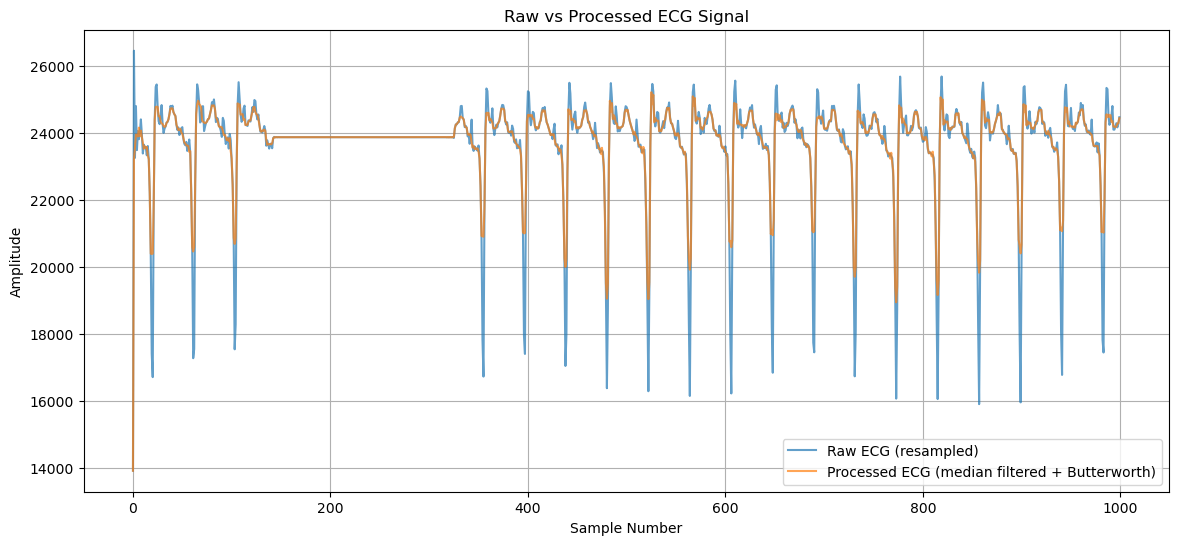

In [7]:
# --- Step 9: Plot comparison on sample ---
processed_files = [f for f in os.listdir(filtered_folder) if f.endswith('.npy')]
sample_processed_file = processed_files[0]
sample_raw_file = sample_processed_file.replace('_processed.npy', '_ecg.npy')

raw_ecg = np.load(os.path.join(np_folder, sample_raw_file))
processed_ecg = np.load(os.path.join(filtered_folder, sample_processed_file))

def simple_resample(data, orig_fs, target_fs):
    from math import gcd
    g = gcd(int(orig_fs), int(target_fs))
    up = int(target_fs // g)
    down = int(orig_fs // g)
    data = data[:, np.newaxis] if data.ndim == 1 else data
    return resample_poly(data, up, down, axis=0).squeeze()

raw_ecg_resampled = simple_resample(raw_ecg, original_fs, target_fs)

plt.figure(figsize=(14,6))
plt.plot(raw_ecg_resampled[:1000], label='Raw ECG (resampled)', alpha=0.7)
plt.plot(processed_ecg[:1000], label='Processed ECG (median filtered + Butterworth)', alpha=0.7)
plt.title('Raw vs Processed ECG Signal')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [9]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [10]:
import numpy as np
import pywt
import os
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar

In [11]:
# --- Segment ECG signal into windows ---
def segment_signal(signal, fs=45, window_sec=30, overlap_sec=5):
    window_len = int(window_sec * fs)
    overlap_len = int(overlap_sec * fs)
    step = window_len - overlap_len
    segments = []
    for start in range(0, len(signal) - window_len + 1, step):
        segments.append(signal[start:start + window_len])
    return segments

# --- Compute CWT (Morlet) for each segment and extract features ---
def compute_cwt_features(segment, fs=45, wavelet='morl', scales=None):
    if scales is None:
        scales = np.arange(1, 128)  # Range of scales for Morlet wavelet

    # Compute CWT using Morlet wavelet
    coefficients, _ = pywt.cwt(segment, scales, wavelet, 1/fs)

    # Extract features: Mean and Variance of the CWT coefficients
    mean_coeff = np.mean(np.abs(coefficients), axis=1)  # Mean of CWT coefficients
    var_coeff = np.var(np.abs(coefficients), axis=1)  # Variance of CWT coefficients

    # Combine the mean and variance as features
    cwt_features = np.concatenate([mean_coeff, var_coeff])
    return cwt_features

class ECGCWTFeatureDataset(Dataset):
    def __init__(self, np_folder, labels_dict, fs=45, window_sec=30, overlap_sec=5):
        self.fs = fs
        self.window_sec = window_sec
        self.overlap_sec = overlap_sec
        self.samples = []
        self.labels = []

        # Iterate through the processed ECG files with tqdm progress bar
        for file in tqdm(os.listdir(np_folder), desc="Processing ECG files", unit="file"):
            if file.endswith('.npy'):
                pid = int(file.split('_')[0])  # Extract patient ID from file name
                ecg = np.load(os.path.join(np_folder, file))  # Load the ECG data

                # Segment the ECG signal into smaller windows
                segments = segment_signal(ecg, fs, window_sec, overlap_sec)

                # Compute CWT features for each segment
                for seg in segments:
                    cwt_features = compute_cwt_features(seg, fs)
                    self.samples.append(cwt_features)
                    self.labels.append(labels_dict[pid])  # Add corresponding label

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        features = self.samples[idx]
        label = self.labels[idx]
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Prepare the labels dictionary from the dataframe (assumed to be already loaded)
labels_dict = dict(zip(df['patient_id'].astype(int), df['label']))

# Path to your processed ECG files
np_folder = 'ecg_resampled_filtered_arrays'  # Folder where your processed .npy files are saved

# Create the dataset and dataloaders
dataset = ECGCWTFeatureDataset(np_folder=np_folder, labels_dict=labels_dict)

Processing ECG files: 100%|██████████| 198/198 [23:12<00:00,  7.03s/file] 


In [12]:
# Save the extracted features and labels as numpy binary files
def save_dataset_to_npy(dataset, save_path_features, save_path_labels):
    # Convert features and labels lists into numpy arrays
    features_array = np.array(dataset.samples)
    labels_array = np.array(dataset.labels)

    # Save the features and labels as .npy files
    np.save(save_path_features, features_array)
    np.save(save_path_labels, labels_array)

    print(f"Features saved to: {save_path_features}")
    print(f"Labels saved to: {save_path_labels}")

# Define file paths to save the features and labels
save_path_features = 'ecg_features.npy'  # You can change the filename/path as needed
save_path_labels = 'ecg_labels.npy'  # You can change the filename/path as needed

# Call the function to save dataset
save_dataset_to_npy(dataset, save_path_features, save_path_labels)

Features saved to: ecg_features.npy
Labels saved to: ecg_labels.npy


In [14]:
import os

# Function to check the size of the saved .npy files
def check_file_size(file_path):
    # Get the file size in bytes
    file_size = os.path.getsize(file_path)
    # Convert bytes to MB
    file_size_mb = file_size / (1024 * 1024)
    return file_size_mb

# Check the size of the saved files
features_size = check_file_size(save_path_features)
labels_size = check_file_size(save_path_labels)

# Print the file sizes
print(f"Size of features file: {features_size:.2f} MB")
print(f"Size of labels file: {labels_size:.2f} MB")

Size of features file: 54.66 MB
Size of labels file: 0.11 MB


In [15]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch
import numpy as np

# Convert the samples and labels lists to numpy arrays
features_array = np.array(dataset.samples)
labels_array = np.array(dataset.labels)

# Split into train and validation (80% train, 20% val)
X_train, X_val, y_train, y_val = train_test_split(
    features_array, labels_array, test_size=0.2, random_state=42, stratify=labels_array
)

print(f"Train samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")

# Define a Dataset class to wrap numpy arrays
class ECGFeatureTensorDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create train and validation Dataset objects
train_dataset = ECGFeatureTensorDataset(X_train, y_train)
val_dataset = ECGFeatureTensorDataset(X_val, y_val)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


Train samples: 22566, Validation samples: 5642


In [16]:
import torch.nn as nn
import torch.nn.functional as F

class ECG1DCNN(nn.Module):
    def __init__(self, input_length, num_classes=2):
        super(ECG1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)

        # Calculate the length after pooling
        pooled_length = input_length // 2 // 2  # two poolings with stride 2

        self.fc1 = nn.Linear(64 * pooled_length, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: (batch_size, 1, input_length)
        x = self.pool(F.relu(self.conv1(x)))  # -> (batch_size, 32, input_length/2)
        x = self.pool(F.relu(self.conv2(x)))  # -> (batch_size, 64, input_length/4)
        x = x.view(x.size(0), -1)              # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [17]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_length = train_dataset.features.shape[1]
model = ECG1DCNN(input_length=input_length).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        features = features.unsqueeze(1)  # add channel dim

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * features.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            features = features.unsqueeze(1)
            outputs = model(features)
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    val_acc = correct_val / total_val

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/10 - Loss: 135972.5715, Train Acc: 0.5592, Val Acc: 0.5103
Epoch 2/10 - Loss: 20188.8806, Train Acc: 0.5663, Val Acc: 0.6156
Epoch 3/10 - Loss: 7051.4731, Train Acc: 0.5969, Val Acc: 0.5775
Epoch 4/10 - Loss: 2689.4789, Train Acc: 0.6080, Val Acc: 0.6278
Epoch 5/10 - Loss: 1358.6007, Train Acc: 0.6161, Val Acc: 0.5482
Epoch 6/10 - Loss: 798.8071, Train Acc: 0.6096, Val Acc: 0.6212
Epoch 7/10 - Loss: 673.8997, Train Acc: 0.6159, Val Acc: 0.6125
Epoch 8/10 - Loss: 437.0029, Train Acc: 0.6059, Val Acc: 0.6095
Epoch 9/10 - Loss: 187.4731, Train Acc: 0.6302, Val Acc: 0.6448
Epoch 10/10 - Loss: 94.3862, Train Acc: 0.6394, Val Acc: 0.6157


In [18]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for features, labels in val_loader:
        features, labels = features.to(device), labels.to(device)
        features = features.unsqueeze(1)  # Add channel dimension
        
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

report = classification_report(all_labels, all_preds, target_names=['Poor', 'Good'])
print(report)

              precision    recall  f1-score   support

        Poor       0.62      0.65      0.63      2905
        Good       0.61      0.58      0.60      2737

    accuracy                           0.62      5642
   macro avg       0.62      0.61      0.61      5642
weighted avg       0.62      0.62      0.62      5642

